In [5]:

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# ___library_import_statements___
import pandas as pd

# for pandas_datareader, otherwise it might have issues, sometimes there is some version mismatch
pd.core.common.is_list_like = pd.api.types.is_list_like

# make pandas to print dataframes nicely
pd.set_option('expand_frame_repr', False)  

import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
import datetime
import time

#newest yahoo API 
import yfinance as yahoo_finance

#optional 
#yahoo_finance.pdr_override()

%matplotlib inline

In [9]:
ticker = 'TCS.NS'



start_time = datetime.datetime(2018, 1, 1)
#end_time = datetime.datetime(2020, 5, 23)
end_time = datetime.datetime.now().date().isoformat()         # today
# yahoo gives only daily historical data
connected = False
while not connected:
    try:
        ticker_df = web.get_data_yahoo(ticker, start=start_time, end=end_time)
        connected = True
        print('connected to yahoo')
    except Exception as e:
        print("type error: " + str(e))
        time.sleep( 5 )
        pass   

# use numerical integer index instead of date    
ticker_df = ticker_df.reset_index()
print(ticker_df.head(5))
df = ticker_df

connected to yahoo
        Date         High          Low         Open        Close     Volume    Adj Close
0 2018-01-01  1347.400024  1317.500000  1341.150024  1322.800049  1351760.0  1227.237061
1 2018-01-02  1334.800049  1310.099976  1330.000000  1315.599976  1920290.0  1220.557373
2 2018-01-03  1334.500000  1315.599976  1316.000000  1319.324951  1257120.0  1224.013306
3 2018-01-04  1331.000000  1320.000000  1325.000000  1328.550049   913082.0  1232.571899
4 2018-01-05  1349.750000  1325.000000  1325.000000  1344.599976  1153706.0  1247.462402


In [24]:
def computeMACD (df, n_fast, n_slow, n_smooth):
    data = df['Adj Close']
    
    fastEMA = data.ewm(span=n_fast, min_periods=n_slow).mean()
    slowEMA = data.ewm(span=n_slow, min_periods=n_slow).mean()
    MACD = pd.Series(fastEMA-slowEMA, name = 'MACD')
    MACDsig = pd.Series(MACD.ewm(span=n_smooth, min_periods=n_smooth).mean(), name='MACDsig')
    MACDhist = pd.Series(MACD - MACDsig, name = 'MACDhist')
    df = df.join(MACD)
    df = df.join(MACDsig)
    df = df.join(MACDhist)
    
    return df

In [25]:
df = computeMACD(df, 12, 26, 9)

ValueError: columns overlap but no suffix specified: Index(['MACD'], dtype='object')

In [12]:
print(df.head())
print(df.tail())

        Date         High          Low         Open        Close     Volume    Adj Close  MACD  MACDsig  MACDhist
0 2018-01-01  1347.400024  1317.500000  1341.150024  1322.800049  1351760.0  1227.237061   NaN      NaN       NaN
1 2018-01-02  1334.800049  1310.099976  1330.000000  1315.599976  1920290.0  1220.557373   NaN      NaN       NaN
2 2018-01-03  1334.500000  1315.599976  1316.000000  1319.324951  1257120.0  1224.013306   NaN      NaN       NaN
3 2018-01-04  1331.000000  1320.000000  1325.000000  1328.550049   913082.0  1232.571899   NaN      NaN       NaN
4 2018-01-05  1349.750000  1325.000000  1325.000000  1344.599976  1153706.0  1247.462402   NaN      NaN       NaN
          Date         High          Low         Open        Close     Volume    Adj Close       MACD    MACDsig   MACDhist
871 2021-07-16  3219.850098  3192.000000  3213.000000  3194.800049  1256526.0  3194.800049  -7.623953  10.404133 -18.028086
872 2021-07-19  3199.800049  3176.000000  3180.000000  3184.600098  

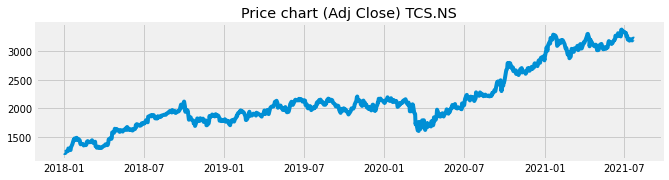

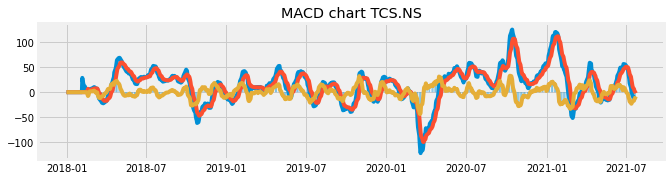

In [13]:
plt.figure(figsize=(10,2.5))
plt.plot(df['Date'], df['Adj Close'])
plt.title('Price chart (Adj Close) ' + str(ticker))
plt.show()

# plot correspondingRSI values and significant levels
plt.figure(figsize=(10,2.5))
plt.title('MACD chart ' + str(ticker))
plt.plot(df['Date'], df['MACD'].fillna(0))
plt.plot(df['Date'], df['MACDsig'].fillna(0))
plt.plot(df['Date'], df['MACDhist'].fillna(0))
plt.bar(df['Date'], df['MACDhist'].fillna(0), width=0.5, snap=False)

plt.show()

In [14]:
def generate_signals(df):
    buy_list = []
    sell_list = []
    flag = -1
    
    for i in range(0,len(df)):
        if df['MACD'][i] > df['MACDsig'][i]:         # first occurence of MACD crossing above signal oine
            sell_list.append(np.nan)                 # so first flip above means buy
            if flag != 1:                            # after first occurence I record flip to ignore
                buy_list.append(df['Close'][i])      # from here onwards
                flag = 1
            else:
                buy_list.append(np.nan)
        elif df['MACD'][i] < df['MACDsig'][i]:
            buy_list.append(np.nan)
            if flag != 0:
                sell_list.append(df['Close'][i])
                flag = 0
            else:
                sell_list.append(np.nan)
        else:
            buy_list.append(np.nan)
            sell_list.append(np.nan)
            
    return (buy_list, sell_list)            


# create buy and sell column
signal = generate_signals(df)
df['buy_sig'] = signal[0]
df['sell_sig'] = signal[1]

In [15]:
df

,Date,High,Low,Open,Close,Volume,Adj Close,MACD,MACDsig,MACDhist,buy_sig,sell_sig
0,2018-01-01,1347.400024,1317.500000,1341.150024,1322.800049,1351760.0,1227.237061,NaN,NaN,NaN,NaN,NaN
1,2018-01-02,1334.800049,1310.099976,1330.000000,1315.599976,1920290.0,1220.557373,NaN,NaN,NaN,NaN,NaN
2,2018-01-03,1334.500000,1315.599976,1316.000000,1319.324951,1257120.0,1224.013306,NaN,NaN,NaN,NaN,NaN
3,2018-01-04,1331.000000,1320.000000,1325.000000,1328.550049,913082.0,1232.571899,NaN,NaN,NaN,NaN,NaN
4,2018-01-05,1349.750000,1325.000000,1325.000000,1344.599976,1153706.0,1247.462402,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
871,2021-07-16,3219.850098,3192.000000,3213.000000,3194.800049,1256526.0,3194.800049,-7.623953,10.404133,-18.028086,NaN,NaN
872,2021-07-19,3199.800049,3176.000000,3180.000000,3184.600098,1597058.0,3184.600098,-10.722637,6.178779,-16.901416,NaN,NaN
873,2021-07-20,3215.000000,3156.149902,3184.600098,3205.800049,1811945.0,3205.800049,-11.337021,2.675619,-14.012641,NaN,NaN
874,2021-07-22,3224.949951,3190.000000,3190.000000,3216.350098,2859334.0,3216.350098,-10.847581,-0.029021,-10.818560,NaN,NaN


In [16]:
def plot_signals(df, ticker):
    # plot price
    plt.figure(figsize=(15,5))
    plt.plot(df['Date'], df['Adj Close'])
    plt.title('Price chart (Adj Close) ' + str(ticker))
    plt.show()

    # plot  values and significant levels
    plt.figure(figsize=(15,5))
    plt.title('Bollinger Bands chart ' + str(ticker))
    plt.plot(df['Date'], df['High'], label='High', alpha=0.2)
    plt.plot(df['Date'], df['Low'], label='Low', alpha=0.2)
    plt.plot(df['Date'], df['Adj Close'], label='Adj Close', color='blue', alpha=0.3)

    plt.scatter(df['Date'], df['buy_sig'], label='Buy', marker='^')
    plt.scatter(df['Date'], df['sell_sig'], label='Sell', marker='v')

    plt.legend()

    plt.show()
       
    plt.figure(figsize=(15,5))
    plt.title('MACD chart ' + str(ticker))
    plt.plot(df['Date'], df['MACD'].fillna(0))
    plt.plot(df['Date'], df['MACDsig'].fillna(0))
    plt.plot(df['Date'], df['MACDhist'].fillna(0))
    plt.bar(df['Date'], df['MACDhist'].fillna(0), width=0.5, snap=False)
    
    return None

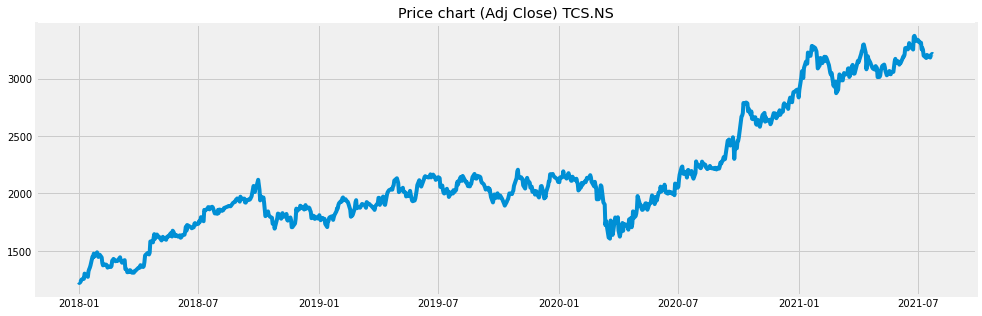

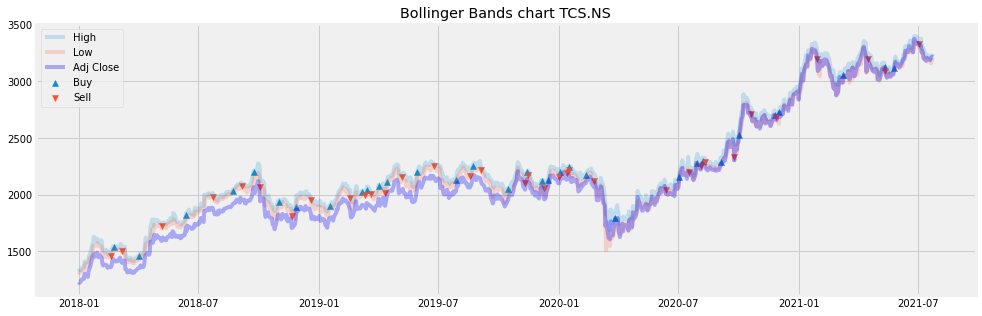

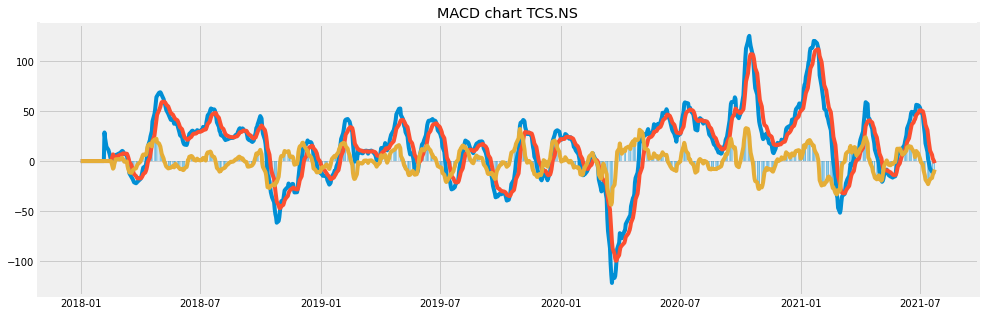

In [17]:
plot_signals(df, ticker)

In [18]:
def get_EMA(df, n=7):
    # computes 200 EMA
    ema = df['Adj Close'].ewm(span=n, adjust=False).mean()
    ema_200 = df['Adj Close'].ewm(span=200, adjust=False).mean()
    
    df['EMA'] = ema
    df['EMA_200'] = ema_200
    
    return df

In [19]:
df = get_EMA(df, 7)

In [20]:
def generate_signals(df):
    buy_list = []
    sell_list = []
    flag = -1
    
    for i in range(0,len(df)):
        # BUY
        if (df['MACD'][i] > df['MACDsig'][i]):      # first occurence of MACD crossing above signal oine
            sell_list.append(np.nan)                # so first flip above means buy
            if (flag != 1) :                        # after first occurence i record flip to ignore
                                                    # from here onwards
                flag = 1
                
                # looking for higher magnitudes 
                if (   (df['High'][i] > df['EMA'][i])               and   \
                    #(df['MACD'][i] < (-2) )                        and   \
                    (df['MACD'][i] < 0)   ):
                    buy_list.append(df['Close'][i])
                #elif (df['MACD'][i] < (-3) ):   #override
                #    buy_list.append(df['Close'][i])
                
                else:
                    buy_list.append(np.nan) 
                
            else:
                buy_list.append(np.nan)
        
        # SELL
        elif (df['MACD'][i] < df['MACDsig'][i]):
            
            buy_list.append(np.nan)
            if (flag != 0) :
                flag = 0
                
                # looking for higher magnitudes
                if ( (df['Low'][i] < df['EMA'][i])                and    \
                    #(df['MACD'][i] > 2)                          and    \
                    (df['MACD'][i] > 0)   ) :
                    sell_list.append(df['Close'][i])
                #elif (df['MACD'][i] > 3 ):   #override
                #    sell_list.append(df['Close'][i])    
                else:
                    sell_list.append(np.nan)    
                
            else:
                sell_list.append(np.nan)
        
        else:
            buy_list.append(np.nan)
            sell_list.append(np.nan)
            
    return (buy_list, sell_list)            


# create buy and sell column
signal = generate_signals(df)
df['buy_sig'] = signal[0]
df['sell_sig'] = signal[1]

In [22]:
def plot_signals_aligned(df, ticker):
    
    import matplotlib.gridspec as gridspec
    
    gs =  gridspec.GridSpec(3,1)
    fig = plt.figure(figsize=(15,15))   
       
       
    # __first plot__
    ax1 = fig.add_subplot(gs[0])

    ax1.plot(df['Date'], df['Adj Close'], label='Adj Close')
    ax1.set_title('Price chart (Adj Close) ' + str(ticker))
    ax1.legend()

    
    # __second plot__
    # plot  values and significant levels
    ax2 = fig.add_subplot(gs[1], sharex=ax1)
    ax2.set_title('Bollinger Bands chart ' + str(ticker))
    ax2.plot(df['Date'], df['High'], label='High', alpha=0.2)
    ax2.plot(df['Date'], df['Low'], label='Low', alpha=0.2)
    ax2.plot(df['Date'], df['Adj Close'], label='Adj Close', color='blue', alpha=0.3)

    ax2.plot(df['Date'], df['EMA'], label='EMA', color='grey', alpha=0.3)
    ax2.plot(df['Date'], df['EMA_200'], label='EMA_200', color='grey', alpha=0.3)
    
    ax2.scatter(df['Date'], df['buy_sig'], label='Buy', marker='^', s=80)
    ax2.scatter(df['Date'], df['sell_sig'], label='Sell', marker='v', s=80)

    ax2.legend()
    
    # __third plot__
    ax3 = fig.add_subplot(gs[2], sharex=ax2)

    ax3.set_title('MACD chart ' + str(ticker))
    ax3.plot(df['Date'], df['MACD'].fillna(0), label='MACD')
    ax3.plot(df['Date'], df['MACDsig'].fillna(0), label='MACDsig')
    ax3.plot(df['Date'], df['MACDhist'].fillna(0), label='MACDhist')
    ax3.bar(df['Date'], df['MACDhist'].fillna(0), width=0.5, snap=False, label='MACDhist')
    ax3.legend()
    
    plt.show()
    
    return None

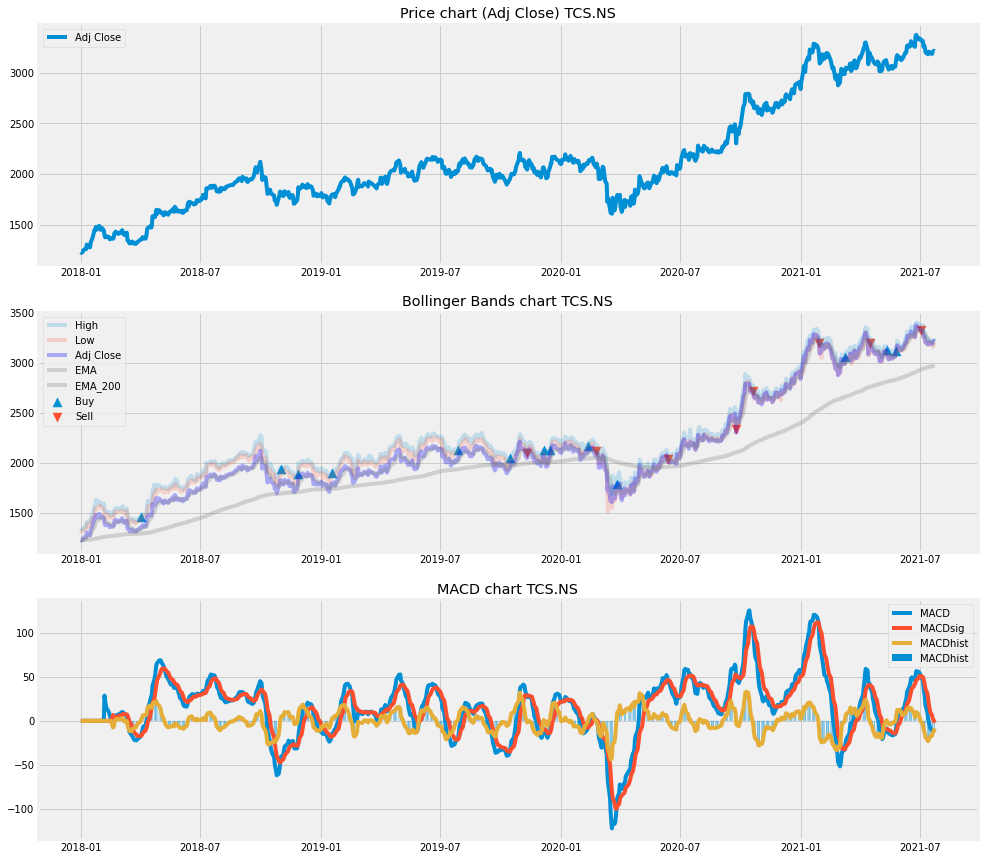

In [23]:
plot_signals_aligned(df, ticker)